In [ ]:
!pip install transformers datasets

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import requests
from tqdm import tqdm


In [ ]:


def download_alpaca_dataset():
    """
    Download the Alpaca dataset
    """
    print("Downloading Alpaca dataset...")

    # Download dataset
    url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        df = pd.DataFrame(data)

        print(f"Successfully downloaded dataset, {len(df)} examples")
        return df
    else:
        raise Exception(f"Failed to download dataset: {response.status_code}")


In [ ]:

def preprocess_alpaca(df):
    """
    Preprocess the Alpaca dataset
    """
    df = df.dropna()

    # Standard system prompt
    system_prompt = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe."

    # Check which format we're working with
    if 'instruction' in df.columns and 'input' in df.columns:
        # We have separate instruction and input columns
        def format_from_separate_fields(row):
            instruction = row['instruction'].strip()

            # Handle input if it exists
            if pd.notna(row['input']) and row['input']:
                user_message = f"{instruction}\n\n{row['input'].strip()}"
            else:
                user_message = instruction

            # Create Llama-3.2 format
            llama3_prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system_prompt}<|start_header_id|>user<|end_header_id|>\n{user_message}<|start_header_id|>assistant<|end_header_id|>\n"
            llama3_output = f"{row['output']}<|end_of_text|>"

            return {
                'llama3_prompt': llama3_prompt,
                'llama3_output': llama3_output
            }

        formatted_data = df.apply(format_from_separate_fields, axis=1)

    else:
        # Combined prompt field containing "Instruction:" and possibly "Input:"
        def format_from_prompt_field(row):
            prompt = row['prompt'].strip()

            # Extract instruction and input parts
            if "Instruction:" in prompt and "Input:" in prompt:
                parts = prompt.split("Input:", 1)
                instruction = parts[0].replace("Instruction:", "", 1).strip()
                input_text = parts[1].strip()
                user_message = f"{instruction}\n\n{input_text}"
            elif "Instruction:" in prompt:
                instruction = prompt.replace("Instruction:", "", 1).strip()
                user_message = instruction
            else:
                user_message = prompt

            # Create Llama-3.2 format
            llama3_prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system_prompt}<|start_header_id|>user<|end_header_id|>\n{user_message}<|start_header_id|>assistant<|end_header_id|>\n"
            llama3_output = f"{row['output']}<|end_of_text|>"

            return {
                'llama3_prompt': llama3_prompt,
                'llama3_output': llama3_output
            }

        formatted_data = df.apply(format_from_prompt_field, axis=1)

    # Add the new columns to the dataframe
    df['llama3_prompt'] = formatted_data.apply(lambda x: x['llama3_prompt'])
    df['llama3_output'] = formatted_data.apply(lambda x: x['llama3_output'])

    # Create complete samples for training (input + output)
    df['llama3_complete'] = df['llama3_prompt'] + df['llama3_output']

    return df


In [ ]:

def analyze_dataset(df):
    """
    Plot input/output length of the dataset
    """


    # Visualize length distributions
    plt.figure(figsize=(12, 6))

    if 'instruction_length' in df.columns and 'output_length' in df.columns:
        plt.subplot(1, 2, 1)
        sns.histplot(df['instruction_length'], bins=50, kde=True)
        plt.title('Instruction Length Distribution')
        plt.xlabel('Character Length')

        plt.subplot(1, 2, 2)
        sns.histplot(df['output_length'], bins=50, kde=True)
        plt.title('Output Length Distribution')
        plt.xlabel('Character Length')

        plt.tight_layout()
        plt.savefig('alpaca_length_distributions.png')


    return df


In [ ]:
df = download_alpaca_dataset()

Successfully downloaded dataset, 52002 examples


In [ ]:
print("Dataset columns: ",df.columns)

Dataset columns:  Index(['instruction', 'input', 'output'], dtype='object')


In [ ]:
df[df['input'] != ""].head()

,instruction,input,output
5,Identify the odd one out.,"Twitter, Instagram, Telegram",Telegram
6,Explain why the following fraction is equivale...,4/16,The fraction 4/16 is equivalent to 1/4 because...
9,Evaluate this sentence for spelling and gramma...,He finnished his meal and left the resturant,He finished his meal and left the restaurant.
14,"Classify the following into animals, plants, a...","Oak tree, copper ore, elephant",Oak tree: Plant\n Copper ore: Mineral\n Elepha...
17,Reverse engineer this code to create a new ver...,def factorialize(num):\n factorial = 1\n for...,def factorialize(num):\n factorial = 1\n for...


In [ ]:
df = preprocess_alpaca(df)


In [ ]:
print("Number of examples after preprocesssing", len(df))

Number of examples after preprocesssing 52002


In [ ]:
print("Preprocessed dataset columns: ",df.columns)

Preprocessed dataset columns:  Index(['instruction', 'input', 'output', 'llama3_prompt', 'llama3_output',
       'llama3_complete'],
      dtype='object')


In [ ]:

df['instruction_length'] = df['instruction'].str.len()
print("\nInstruction Length Statistics:")
print(df['instruction_length'].describe())


df['output_length'] = df['output'].str.len()
print("\nOutput Length Statistics:")
print(df['output_length'].describe())



Instruction Length Statistics:
count    52002.000000
mean        59.778759
std         21.193591
min          9.000000
25%         46.000000
50%         57.000000
75%         70.000000
max        489.000000
Name: instruction_length, dtype: float64

Output Length Statistics:
count    52002.000000
mean       270.312334
std        275.025960
min          0.000000
25%         53.000000
50%        185.000000
75%        423.000000
max       4181.000000
Name: output_length, dtype: float64


In [ ]:
df.head()

,instruction,input,output,llama3_prompt,llama3_output,llama3_complete,instruction_length,output_length
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,<|begin_of_text|><|start_header_id|>system<|en...,1.Eat a balanced diet and make sure to include...,<|begin_of_text|><|start_header_id|>system<|en...,36,202
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",<|begin_of_text|><|start_header_id|>system<|en...,"The three primary colors are red, blue, and ye...",<|begin_of_text|><|start_header_id|>system<|en...,34,51
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",<|begin_of_text|><|start_header_id|>system<|en...,"An atom is made up of a nucleus, which contain...",<|begin_of_text|><|start_header_id|>system<|en...,34,345
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,<|begin_of_text|><|start_header_id|>system<|en...,There are a number of ways to reduce air pollu...,<|begin_of_text|><|start_header_id|>system<|en...,32,472
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,<|begin_of_text|><|start_header_id|>system<|en...,I had to make a difficult decision when I was ...,<|begin_of_text|><|start_header_id|>system<|en...,58,750


In [ ]:
print(df.iloc[14].to_dict())

{'instruction': 'Classify the following into animals, plants, and minerals', 'input': 'Oak tree, copper ore, elephant', 'output': 'Oak tree: Plant\n Copper ore: Mineral\n Elephant: Animal', 'llama3_prompt': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.<|start_header_id|>user<|end_header_id|>\nClassify the following into animals, plants, and minerals\n\nOak tree, copper ore, elephant<|start_header_id|>assistant<|end_header_id|>\n', 'llama3_output': 'Oak tree: Plant\n Copper ore: Mineral\n Elephant: Animal<|end_of_text|>', 'llama3_complete': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.<|start_header_id|>user<|end_header_id|>\nClassify the following into animals, plants, and minerals\n\nOak tree, copper ore, elephant<|start_header_id|>assis

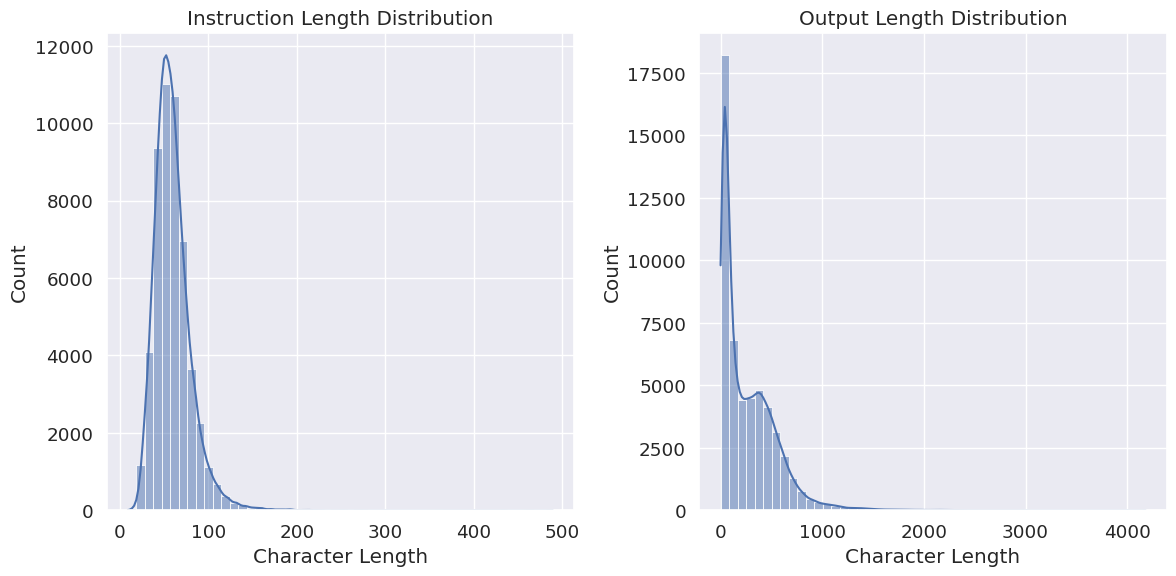

In [ ]:
preprocess_data = analyze_dataset(df)


Common instruction patterns:
instruction_start
What is the                 1011
Generate a list              799
Come up with                 614
Rewrite the following        473
Classify the following       442
Create a list                405
Compare and contrast         355
Given the following          340
What are the                 328
Edit the following           304
Give an example              300
Make a list                  265
Rewrite the sentence         243
Categorize the following     242
Write a short                220
Name: count, dtype: int64


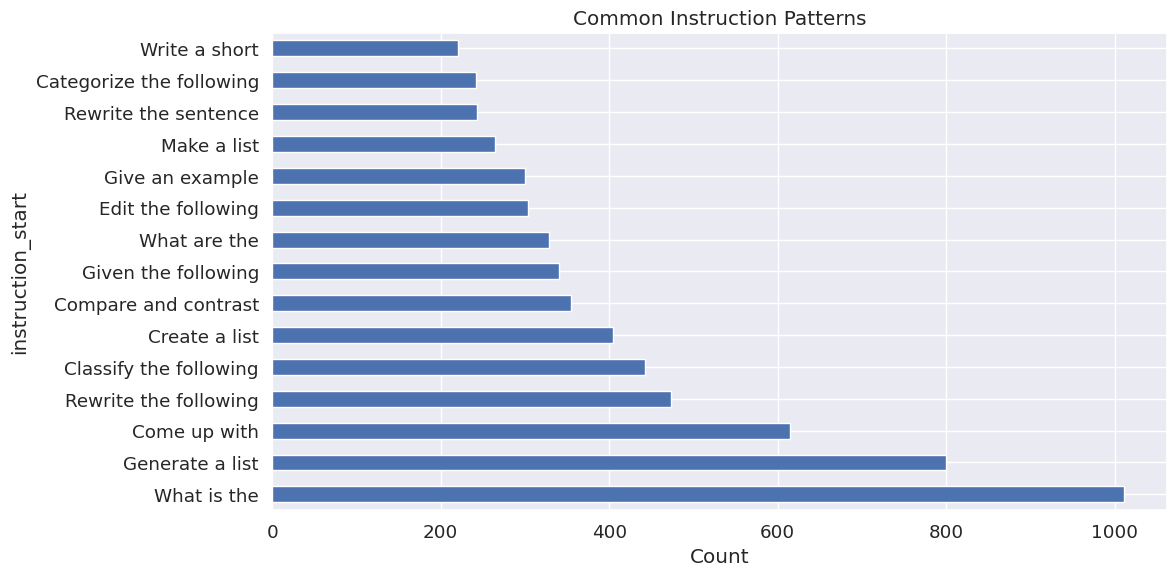

In [ ]:


# Analyze instruction categories
if 'instruction' in df.columns:
        # Extract first few words of instructions to approximate categories
        df['instruction_start'] = df['instruction'].str.split().str[:3].str.join(' ')
        instruction_types = df['instruction_start'].value_counts().head(15)

        plt.figure(figsize=(12, 6))
        instruction_types.plot(kind='barh')
        plt.title('Common Instruction Patterns')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig('alpaca_instruction_patterns.png')

        print("\nCommon instruction patterns:")
        print(instruction_types)

In [ ]:

# Save CSV and JSON formats
preprocess_data.to_csv(f"alpaca_processed.csv", index=False)
preprocess_data.to_json(f"alpaca_processed.json", orient="records", lines=True)